### Exercise 2: Plan-Execute + Reflection Hybrid

**Task:** Combine Plan-Execute and Reflection patterns to create a high-quality multi-step agent.

**Concept:** Use Plan-Execute to break down complex tasks, then use Reflection on the final output to ensure quality.

**Requirements:**
1. Create a hybrid state that includes:
   - Plan-Execute state (input, plan, current_step, results)
   - Reflection state (draft, critique, iterations)
2. Flow: Planner → Executor (loop) → Generator (uses results) → Critic → Refiner (if needed) → Finalizer
3. The Generator creates initial output from all executor results
4. The Critic evaluates the complete output (not individual steps)
5. Refine the final output based on critique (max 2 reflection iterations)
6. Track both execution progress AND reflection quality

**Architecture:**
```
START
  ↓
Planner (creates plan)
  ↓
Executor (executes each step)
  ↓ (loops until all steps done)
  ↓
Generator (synthesizes results into draft)
  ↓
Critic (evaluates quality)
  ↓
Should Refine?
  ↓              ↓
Refiner       Finalizer
  ↓              ↓
Critic         END
  (loops)
```

**Test scenario:**
```
Task: "Research the benefits of Python programming, create a summary, and make it beginner-friendly"

Expected flow:
1. PLAN: 
   - Step 1: Search for Python benefits
   - Step 2: Identify key benefits
   - Step 3: Create summary
2. EXECUTE: Complete all steps
3. GENERATE: Create initial summary from results
4. REFLECT: Critique summary for beginner-friendliness
5. REFINE: Simplify language and add examples
6. FINAL: High-quality, beginner-friendly summary
```

**Deliverables:**
1. Combined state definition (TypedDict)
2. All necessary nodes (planner, executor, generator, critic, refiner, finalizer)
3. Graph with proper edges and conditional routing
4. Test with the scenario above
5. Print output showing:
   - The plan
   - Each execution step
   - Initial draft
   - Critique
   - Refined version (if applicable)
   - Final output

---

In [22]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict, List, Literal
from typing_extensions import Annotated
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated, Literal, Sequence
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage, SystemMessage
from IPython.display import Image, display
import matplotlib.pyplot as plt
from typing import List
import json
import numpy as np
import operator
import os

In [23]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found!")

print("✅ API key loaded")

✅ API key loaded


In [24]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


In [25]:
class HybridState(TypedDict):
    # Plan-Execute
    input: str
    plan: List[str]
    current_step: int
    results: Annotated[List[str], operator.add]

    # Reflection
    draft: str
    critique: str
    iterations: int
    needs_refinement: bool

    # Quality metrics (ADD)
    clarity: int
    completeness: int
    beginner_friendly: int

    # Final
    final_output: str

MAX_REFLECTIONS = 2

In [26]:
def planner(state: HybridState) -> dict:
    prompt = f"""
Create a clear 3–5 step plan for the task.

Task:
{state['input']}

Return a numbered list only.
"""
    response = llm.invoke([HumanMessage(content=prompt)])

    steps = [
        line.strip()
        for line in response.content.split("\n")
        if line.strip() and line[0].isdigit()
    ]

    print("\n📋 PLAN:")
    for s in steps:
        print(" ", s)

    return {
        "plan": steps,
        "current_step": 0,
        "results": []
    }



def executor(state: HybridState) -> dict:
    step = state["plan"][state["current_step"]]

    print(f"\n⚙️ Executing step {state['current_step'] + 1}: {step}")

    prompt = f"""
Previous results:
{state['results']}

Execute this step and return useful information only:
{step}
"""
    response = llm.invoke([HumanMessage(content=prompt)])
    result = response.content.strip()

    print("✓ Result:", result[:120], "...")

    return {
        "results": [result],
        "current_step": state["current_step"] + 1
    }

In [27]:
def should_continue_execution(state: HybridState) -> Literal["executor", "generator"]:
    if state["current_step"] < len(state["plan"]):
        return "executor"
    return "generator"

def generator(state: HybridState) -> dict:
    print("\n✍️ Generating initial draft...")

    prompt = f"""
Using the following research results, create a beginner-friendly summary.

Results:
{state['results']}
"""
    response = llm.invoke([HumanMessage(content=prompt)])

    print("\n📄 INITIAL DRAFT:\n", response.content)

    return {
        "draft": response.content,
        "iterations": 0
    }


# CRITIC (QUALITY-BASED)
def critic(state: HybridState) -> dict:
    print("\n🔍 Critiquing draft...")

    prompt = f"""
Score the summary from 1 to 5 on:
- Clarity
- Completeness
- Beginner-friendliness

Return ONLY valid JSON in this format:
{{
  "clarity": 3,
  "completeness": 4,
  "beginner_friendly": 3,
  "feedback": "short explanation"
}}

Summary:
{state['draft']}
"""
    response = llm.invoke([HumanMessage(content=prompt)])

    try:
        data = json.loads(response.content)
        clarity = data["clarity"]
        completeness = data["completeness"]
        beginner_friendly = data["beginner_friendly"]
        critique = data["feedback"]
    except Exception:
        clarity = completeness = beginner_friendly = 3
        critique = response.content

    needs_refinement = (
        clarity < 4 or
        completeness < 4 or
        beginner_friendly < 4
    )

    iteration = state["iterations"] + 1
    decision = "→ Refine" if needs_refinement else "→ Approved!"

    print(
        f"Iteration {iteration}: "
        f"Clarity={clarity}, Completeness={completeness}, "
        f"BeginnerFriendly={beginner_friendly} {decision}"
    )

    print("\n📝 CRITIQUE:\n", critique)

    return {
        "clarity": clarity,
        "completeness": completeness,
        "beginner_friendly": beginner_friendly,
        "critique": critique,
        "needs_refinement": needs_refinement,
        "iterations": iteration
    }


# REFINER
def refiner(state: HybridState) -> dict:
    print(f"\n✍️ Refining draft (iteration {state['iterations']})...")

    prompt = f"""
Improve the summary based on this critique:

Critique:
{state['critique']}

Current draft:
{state['draft']}
"""
    response = llm.invoke([HumanMessage(content=prompt)])

    print("\n📄 REFINED DRAFT:\n", response.content)

    return {"draft": response.content}


# FINALIZER
def finalizer(state: HybridState) -> dict:
    print("\n✅ FINAL OUTPUT READY\n")
    return {"final_output": state["draft"]}




In [28]:
def should_refine(state: HybridState) -> Literal["refiner", "finalizer"]:
    if state["needs_refinement"] and state["iterations"] < MAX_REFLECTIONS:
        return "refiner"
    return "finalizer"

# BUILD GRAPH
builder = StateGraph(HybridState)

builder.add_node("planner", planner)
builder.add_node("executor", executor)
builder.add_node("generator", generator)
builder.add_node("critic", critic)
builder.add_node("refiner", refiner)
builder.add_node("finalizer", finalizer)

builder.add_edge(START, "planner")
builder.add_edge("planner", "executor")

builder.add_conditional_edges(
    "executor",
    should_continue_execution,
    {"executor": "executor", "generator": "generator"}
)

builder.add_edge("generator", "critic")

builder.add_conditional_edges(
    "critic",
    should_refine,
    {"refiner": "refiner", "finalizer": "finalizer"}
)

builder.add_edge("refiner", "critic")
builder.add_edge("finalizer", END)

hybrid_agent = builder.compile()

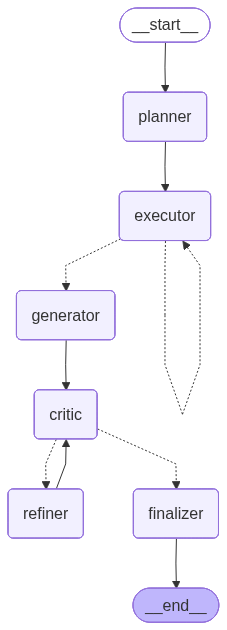

In [30]:
# Visualize
try:
    display(Image(hybrid_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print(
        "Graph: START → planner → executor (loops) → generator → critic "
        "→ refiner (loops back to critic) → finalizer → END"
    )


In [29]:
result = hybrid_agent.invoke({
    "input": "Research the benefits of Python programming, create a summary, and make it beginner-friendly",
    "plan": [],
    "current_step": 0,
    "results": [],
    "draft": "",
    "critique": "",
    "iterations": 0,
    "needs_refinement": True,
    "clarity": 0,
    "completeness": 0,
    "beginner_friendly": 0
})

print("\n" + "=" * 80)
print("🎯 FINAL ANSWER:")
print(result["final_output"])
print("=" * 80)


📋 PLAN:
  1. **Identify Key Benefits**: Research and list the main advantages of Python programming, such as ease of learning, versatility, community support, and libraries/frameworks.
  2. **Gather Resources**: Find beginner-friendly articles, tutorials, and videos that explain Python's benefits in simple terms.
  3. **Draft the Summary**: Write a concise summary of the benefits, using clear and straightforward language suitable for beginners.
  4. **Include Examples**: Add practical examples or use cases for each benefit to illustrate how Python can be applied in real-world scenarios.
  5. **Review and Edit**: Revise the summary for clarity and simplicity, ensuring it is accessible to those new to programming.

⚙️ Executing step 1: 1. **Identify Key Benefits**: Research and list the main advantages of Python programming, such as ease of learning, versatility, community support, and libraries/frameworks.
✓ Result: Here are the key benefits of Python programming:

1. **Ease of Learnin